In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

import time
import torch
import numpy as np
import random

#plotting
import matplotlib.pyplot as plt

# savings
import pandas as pd
import json

import agent

from toolbox import get_word_ix, UniversalConstants, UniversalData, model_best_acc_detector, load_listener_model, load_speaker_model, curiosity

ntokens: 4238


In [2]:
# Required for the functions defined here. They should be imported to toolbox when the function definitions move there.
import numpy as np
from toolbox import load_numpy

In [3]:
import torch.nn as nn
import torch.optim as optim

In [4]:
uc = UniversalConstants()
ud = UniversalData()

setting = 'curious'
which_set = 'val'

# Overlapping Analysis

This notebook intends to do the steps below:

1. [Choose the most accurate random model](#best_random)
2. [Extract the choices on each epoch](#data_extraction)

## 1. Choose the most accurate `random` model <a name="best_random"></a>

In [5]:
# path to the loss_acc results to choose the best model
path_loss_acc = os.path.join('/home', 'u1270964', 'curiosity', 'loss_acc', 'unsupervised/')

In [6]:
# This definition should move to toolbox
def best_model_acc(_path_loss_acc, _agent, _setting, which_set, learning, mode='single'):
    if _agent == 'listener':
            _agent = 'li'
    elif _agent == 'speaker':
            _agent = 'sp'
    else:
        print("put either listener or speaker for agent.")
    
    if mode == 'single':
        
        _the_best = {'best_seed': 0,
                     'best_ep': 0,
                     'best_acc': 0.0}

        for _seed in uc.final_seeds:
            scores = load_numpy(_path_loss_acc, _agent, which_set, 'acc', 0.001, _setting, _seed)
            if max(scores) > _the_best['best_acc']:
                _the_best['best_seed'] = _seed
                _the_best['best_ep'] = scores.argmax() + 1
                _the_best['best_acc'] = scores[_the_best['best_ep'] - 1]
    
    elif mode == 'avg':
        _the_best = {'best_seed': 0,
                     'best_ep': 0,
                     'best_avg_acc': 0.0,
                     'top_acc': 0.0,
                     'min_acc': 0.0,
                     'scores': []}

        for _seed in uc.final_seeds:
            
            scores = load_numpy(_path_loss_acc, _agent, which_set, 'acc', 0.001, _setting, _seed)
            acc_avg = np.mean(scores)
            # acc_avg = np.average(scores, weights=np.arange(1,41))
            if acc_avg > _the_best['best_avg_acc']:
                _the_best['best_seed'] = _seed
                _the_best['best_ep'] = scores.argmax() + 1
                _the_best['best_avg_acc'] = acc_avg
                _the_best['top_acc'] = max(scores)
                _the_best['min_acc'] = min(scores)
                _the_best['scores'] = scores
    else:
        print('mode should be either \'single\' or \'avg\'.')

    return _the_best


-----------------------------------
The most accurate random model is:

Best Seed:		 890 
Avearge Accuracy:	 0.66 
---
Lowest Accuracy:	 0.52 
Highest Accuracy:	 0.69 
----------------------------------- 



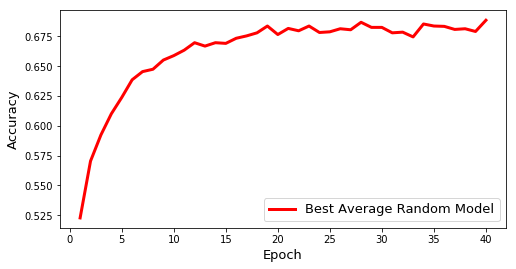

In [7]:
best_random_model = best_model_acc(path_loss_acc, 'listener', setting, which_set, uc.final_seeds, 'avg')

print('\n'+"-"*35+"\nThe most accurate random model is:\n\n"
      +"Best Seed:\t\t", best_random_model['best_seed'],
      "\nAvearge Accuracy:\t", format(best_random_model['best_avg_acc'], '.2f'),
      "\n---\nLowest Accuracy:\t", format(best_random_model['min_acc'], '.2f'),
      "\nHighest Accuracy:\t", format(best_random_model['top_acc'], '.2f'),
      '\n'+"-"*35,'\n')

figure = plt.figure(figsize=[8,4])
plt.plot(np.arange(1,41), best_random_model['scores'],
         label='Best Average Random Model', color="red", linewidth=3)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.xlabel('Epoch', fontsize=13)
plt.show()

In [8]:
random.seed(a=best_random_model['best_seed'])

# setting torch seeds
torch.cuda.manual_seed(best_random_model['best_seed'])
torch.manual_seed(best_random_model['best_seed'])

np.random.seed(best_random_model['best_seed'])

## 2. Extract the choices of different curiosity metrics <a name"data_extraction"></a>

I will load the same model for 

_1. for each epoch:_
>1.1. load the model[epoch]

>1.2. for all img in val_split:
>>1.2.1. for each condition:
>>>1.2.1.1. record the choices

Should check:
    
- difference of train batch set and val batch set

In [9]:
def load_img(_dict_words_boxes, _ha_vggs_indices, _word_to_ix, img, _device, path_vgg):
    vggs = torch.load(path_vgg + img + ".pt").to(_device)  # Edit path
    # dict met obj ids als keys en een dictionary met words : '', bboxes :
    # n = 0
    bbox_indices = []
    words = []
    for obj in _dict_words_boxes[img]:  # For every object in this image
        words.append(get_word_ix(_word_to_ix, _dict_words_boxes[img][obj]["word"]))
        bbox_indices.append(_ha_vggs_indices[img][obj][0])
    visual_input = vggs[bbox_indices, :]
    language_input = torch.tensor(words, dtype=torch.long, device=_device)
    return language_input, visual_input

In [10]:
def curious_look(_dict_words_boxes, _ha_vggs_indices, _img, _setting, _word_to_ix, _device):
    language_input, scene = load_img(_dict_words_boxes, _ha_vggs_indices, _word_to_ix, _img, _device, uc.path_vgg)
    # repeat scene n_objects times as input to listener
    visual_input = scene.expand(scene.size()[0], scene.size()[0], scene.size()[1])
    curiosity_targets = torch.eye(visual_input.size()[0], dtype=torch.float, device=ud.device)
    # targets is simply 0, 1, ...., n because they are in order of appearance
    targets = torch.tensor([i for i in range(len(language_input))], dtype=torch.long, device=ud.device)
    # word guesses by child - use as attention over word embeddings
    word_guesses = speaker(visual_input, curiosity_targets, apply_softmax=False)
    # only keep most likely words
    words = torch.argmax(word_guesses, dim=1)
    # give these as input to listener
    object_guesses = listener(words, visual_input)
    curiosity_values = curiosity(curiosity_targets, object_guesses, _setting)
    max_curious = torch.argmax(curiosity_values)
    return max_curious

In [11]:
def pair_count(list_1, list_2):
    pair_check = []
    
    if len(list_1)==len(list_2):
        for _index in range(len(list_1)):
            if list_1[_index] == list_2[_index]:
                pair_check.append(1)
            else:
                pair_check.append(0)
    else:
        print("THE LISTS SHOULD HAVE THE SAME LENGTH!")
    
    pair_count = pair_check.count(1)
    
    return {'count': pair_count, 'vec': pair_check}

In [12]:
def trip_count(list_1, list_2, list_3):
    trip_check = []
    
    if (len(list_1)==len(list_2)) and (len(list_2)==len(list_3)):
        for _index in range(len(list_1)):
            if (list_1[_index] == list_2[_index]) and (list_2[_index] == list_3[_index]):
                trip_check.append(1)
            else:
                trip_check.append(0)
    else:
        print("THE LISTS SHOULD HAVE THE SAME LENGTH!")
    
    trip_count = trip_check.count(1)
    
    return {'count': trip_count, 'vec': trip_check}

In [13]:
trip_count([1,2,3,4], [4,2,3,4], [1,2,6,4])

{'count': 2, 'vec': [0, 1, 0, 1]}

In [14]:
def load_listener_models(path_models_folder, _word_to_ix, _device, setting: str = 'curious', epoch: int = 0, lr: float = 0.001,
                        seed: int = 123) -> agent.Listener:
    """
    Loads the listener model
    -----

    :param _word_to_ix:
    :type _word_to_ix:
    :param _device:
    :type _device:
    :param path_models_folder:
    :type path_models_folder:
    :param setting:
    :type setting:
    :param epoch:
    :type epoch:
    :param lr:
    :type lr:
    :param seed:
    :type seed:
    :return:
    :rtype:
    """
    path_wanted_model = os.path.join(path_models_folder, setting,
                                     'liModel_{}_{}_{}_ep{}.pth'.format(setting, lr, seed, epoch))

    uc = UniversalConstants()

    ntokens = len(_word_to_ix.keys())

    # initializing the model
    model = agent.Listener(uc.object_size, ntokens, uc.wordemb_size,
                           uc.att_hidden_size, nonlinearity=uc.nonlin).to(_device)
    # load state_dict to it
    checkpoint = torch.load(path_wanted_model)
    model.load_state_dict(checkpoint)
    print("\nModel's state_dict:")  # print the loaded state_dict
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print((('-' * 60) + '\n') * 2)

    return model

In [15]:
def load_speaker_models(path_models_folder, _word_to_ix, _device, setting: str = 'curious', epoch: int = 0, lr: float = 0.001,
                        seed: int = 123) -> agent.Speaker:
    """
    Loads the Speaker model
    -----

    :param _word_to_ix:
    :type _word_to_ix:
    :param _device:
    :type _device:
    :param path_models_folder:
    :type path_models_folder:
    :param setting:
    :type setting:
    :param epoch:
    :type epoch:
    :param lr:
    :type lr:
    :param seed:
    :type seed:
    :return:
    :rtype:
    """
    path_wanted_model = os.path.join(path_models_folder, setting,
                                     'spModel_{}_{}_{}_ep{}.pth'.format(setting, lr, seed, epoch))

    uc = UniversalConstants()
    ntokens = len(_word_to_ix.keys())

    # initializing the model
    model = agent.Speaker(uc.object_size, ntokens, uc.att_hidden_size, nonlinearity=uc.nonlin).to(_device)
    # load state_dict to it
    checkpoint = torch.load(path_wanted_model)
    model.load_state_dict(checkpoint)
    print("\nModel's state_dict:")  # print the loaded state_dict
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print((('-' * 60) + '\n') * 2)

    return model

In [16]:
start_time = time.time()

y = {}
for _seed in uc.final_seeds:
    y[str(_seed)] = {
        'pl_sn': [],
        'pl_cu': [],
        'cu_sn': [],
        'all': []
    }
    
averaging = {
        'pl_sn': [],
        'pl_cu': [],
        'cu_sn': [],
        'all': []
        }

epochs = np.arange(0,41)

curious_choices = {}
for _seed in uc.final_seeds:
    curious_choices[str(_seed)] = {}
    for epoch in ["ep"+str(ep) for ep in epochs]:
        curious_choices[str(_seed)][epoch] = {
            'single': {
                'pl': [],
                'sn': [],
                'cu': []
            },
            'pair': {
                'pl_sn': {'vec': [], 'match': 0},
                'pl_cu': {'vec': [], 'match': 0},
                'cu_sn': {'vec': [], 'match': 0},
                'all': {'vec': [], 'match': 0}
            }
        
        }

for epoch in epochs:
    
    print("\n*************\n|EPOCH:\t", epoch, "|\n*************\n\n")
    # load all the models of the specified setting with all the seeds.
    suming = {
        'pl_sn': 0,
        'pl_cu': 0,
        'cu_sn': 0,
        'all': 0
        }
    for _seed in uc.final_seeds:
        print("\n- - - - - - - -\n|SEED:\t", _seed, "|\n- - - - - - - -\n\n")
        listener = load_listener_models("/home/u1270964/curiosity/unsupervised/models/", ud.indexed_vocab, uc.device, setting, epoch, 0.001, _seed)
        speaker = load_speaker_models("/home/u1270964/curiosity/unsupervised/models/", ud.indexed_vocab, uc.device, setting, epoch, 0.001, _seed)
        listener.eval()
        speaker.eval()
    
        # batch = 0
        n_batches = len(ud.val_batchlist)
    
        for batch_n in range(n_batches):
            for img in ud.val_batchlist[batch_n]:
                curious_choices[str(_seed)]["ep"+str(epoch)]['single']['pl'].append(curious_look(ud.dict_words_boxes, ud.ha_vggs_indices, img, 'plasticity', ud.indexed_vocab, uc.device).item())
                curious_choices[str(_seed)]["ep"+str(epoch)]['single']['sn'].append(curious_look(ud.dict_words_boxes, ud.ha_vggs_indices, img, 'sn', ud.indexed_vocab, uc.device).item())
                curious_choices[str(_seed)]["ep"+str(epoch)]['single']['cu'].append(curious_look(ud.dict_words_boxes, ud.ha_vggs_indices, img, 'curious', ud.indexed_vocab, uc.device).item())
    
        curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['pl_sn'] = pair_count(curious_choices[str(_seed)]["ep"+str(epoch)]['single']['pl'], curious_choices[str(_seed)]["ep"+str(epoch)]['single']['sn'])
        curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['pl_cu'] = pair_count(curious_choices[str(_seed)]["ep"+str(epoch)]['single']['pl'], curious_choices[str(_seed)]["ep"+str(epoch)]['single']['cu'])
        curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['cu_sn'] = pair_count(curious_choices[str(_seed)]["ep"+str(epoch)]['single']['cu'], curious_choices[str(_seed)]["ep"+str(epoch)]['single']['sn'])
        curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['all'] = trip_count(curious_choices[str(_seed)]["ep"+str(epoch)]['single']['pl'], curious_choices[str(_seed)]["ep"+str(epoch)]['single']['sn'], curious_choices[str(_seed)]["ep"+str(epoch)]['single']['cu'])
        
        y[str(_seed)]['pl_sn'].append(curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['pl_sn']['count'])
        suming['pl_sn'] += curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['pl_sn']['count']
        
        y[str(_seed)]['pl_cu'].append(curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['pl_cu']['count'])
        suming['pl_cu'] += curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['pl_cu']['count']
        
        y[str(_seed)]['cu_sn'].append(curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['cu_sn']['count'])
        suming['cu_sn'] += curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['cu_sn']['count']
        
        y[str(_seed)]['all'].append(curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['all']['count'])
        suming['all'] += curious_choices[str(_seed)]["ep"+str(epoch)]['pair']['all']['count']
    
    averaging['pl_sn'].append(suming['pl_sn']/len(uc.final_seeds))
    averaging['pl_cu'].append(suming['pl_cu']/len(uc.final_seeds))
    averaging['cu_sn'].append(suming['cu_sn']/len(uc.final_seeds))
    averaging['all'].append(suming['all']/len(uc.final_seeds))
end_time = time.time()

print("\n\n", "-^*"*10,"\n", "Total running time:\t", format(end_time-start_time, '.2f'), "\n", "-^*"*10,"\n")


*************
|EPOCH:	 0 |
*************



- - - - - - - -
|SEED:	 123 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 234 |
- - -


- - - - - - - -
|SEED:	 12 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 23 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 1 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 100 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 890 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 901 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 89 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 90 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 678 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 789 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 67 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 78 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 456 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 567 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 45 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 56 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 234 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 345 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 23 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 34 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 100 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


*************
|EPOCH:	 5 |
*************



- - - - - - - -
|SEED:	 123 |
- - -


- - - - - - - -
|SEED:	 901 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 12 |
- - - - - - - -


Initializing word embeddings
Ini


- - - - - - - -
|SEED:	 90 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 1 |
- - - - - - - -


Initializing word embeddings
Initi


- - - - - - - -
|SEED:	 789 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 890 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 78 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 89 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 567 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 678 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 56 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 67 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 345 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 456 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 34 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 45 |
- - - - - - - -


Initializing word embeddings
Init


*************
|EPOCH:	 9 |
*************



- - - - - - - -
|SEED:	 123 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 234 |
- - -


- - - - - - - -
|SEED:	 12 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 23 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 1 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 100 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 890 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 901 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 89 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 90 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 678 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 789 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 67 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 78 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 456 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 567 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 45 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 56 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 234 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 345 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 23 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 34 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 100 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


*************
|EPOCH:	 14 |
*************



- - - - - - - -
|SEED:	 123 |
- - 


- - - - - - - -
|SEED:	 901 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 12 |
- - - - - - - -


Initializing word embeddings
Ini


- - - - - - - -
|SEED:	 90 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 1 |
- - - - - - - -


Initializing word embeddings
Initi


- - - - - - - -
|SEED:	 789 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 890 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 78 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 89 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 567 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 678 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 56 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 67 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 345 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 456 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 34 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 45 |
- - - - - - - -


Initializing word embeddings
Init


*************
|EPOCH:	 18 |
*************



- - - - - - - -
|SEED:	 123 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 234 |
- - 


- - - - - - - -
|SEED:	 12 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 23 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 1 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 100 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 890 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 901 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 89 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 90 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 678 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 789 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 67 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 78 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 456 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 567 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 45 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 56 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 234 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 345 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 23 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 34 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 100 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


*************
|EPOCH:	 23 |
*************



- - - - - - - -
|SEED:	 123 |
- - 


- - - - - - - -
|SEED:	 901 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 12 |
- - - - - - - -


Initializing word embeddings
Ini


- - - - - - - -
|SEED:	 90 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 1 |
- - - - - - - -


Initializing word embeddings
Initi


- - - - - - - -
|SEED:	 789 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 890 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 78 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 89 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 567 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 678 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 56 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 67 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 345 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 456 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 34 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 45 |
- - - - - - - -


Initializing word embeddings
Init


*************
|EPOCH:	 27 |
*************



- - - - - - - -
|SEED:	 123 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 234 |
- - 


- - - - - - - -
|SEED:	 12 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 23 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 1 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 100 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 890 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 901 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 89 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 90 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 678 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 789 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 67 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 78 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 456 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 567 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 45 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 56 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 234 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 345 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 23 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 34 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 100 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


*************
|EPOCH:	 32 |
*************



- - - - - - - -
|SEED:	 123 |
- - 


- - - - - - - -
|SEED:	 901 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 12 |
- - - - - - - -


Initializing word embeddings
Ini


- - - - - - - -
|SEED:	 90 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 1 |
- - - - - - - -


Initializing word embeddings
Initi


- - - - - - - -
|SEED:	 789 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 890 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 78 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 89 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 567 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 678 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 56 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 67 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 345 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 456 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 34 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 45 |
- - - - - - - -


Initializing word embeddings
Init


*************
|EPOCH:	 36 |
*************



- - - - - - - -
|SEED:	 123 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 234 |
- - 


- - - - - - - -
|SEED:	 12 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 23 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 1 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 100 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 890 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 901 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 89 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 90 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 678 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 789 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 67 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 78 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 456 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 567 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 45 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 56 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 234 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 345 |
- - - - - - - -


Initializing word embeddings
In


- - - - - - - -
|SEED:	 23 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


- - - - - - - -
|SEED:	 34 |
- - - - - - - -


Initializing word embeddings
Init


- - - - - - - -
|SEED:	 100 |
- - - - - - - -


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------



 -^*-^*-^*-^*-^*-^*-^*-^*-^*-^* 
 Total running time:	 2691.79 
 -^*-^*-^*-^*-

## Plot
Here we make the plot

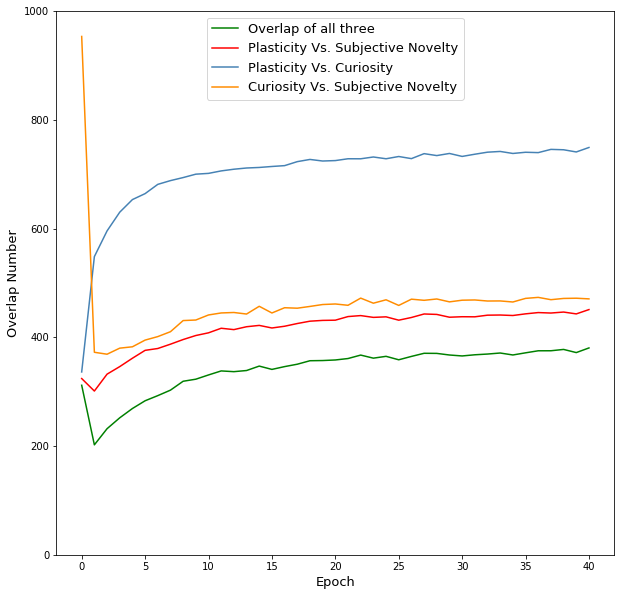

In [17]:
figure = plt.figure(figsize=[10,10])
figure.subplots_adjust(hspace=0.4, wspace=0.3)

plt.ylim(0,1000)  # Limit the Y axis
plt.plot(epochs, averaging['all'],
         label='Overlap of all three', color="Green", linewidth=1.5)
plt.plot(epochs, averaging['pl_sn'],
         label='Plasticity Vs. Subjective Novelty', color="red", linewidth=1.5)
plt.plot(epochs, averaging['pl_cu'],
         label='Plasticity Vs. Curiosity', color="steelblue", linewidth=1.5)
plt.plot(epochs, averaging['cu_sn'],
         label='Curiosity Vs. Subjective Novelty', color="darkorange", linewidth=1.5)

plt.legend(loc='upper center', fontsize=13)
plt.ylabel('Overlap Number', fontsize=13)
plt.xlabel('Epoch', fontsize=13)
plt.show()

## Savings

### Plots

In [18]:
figure.savefig('overlap_results/overlap_averaged_{}.svg'.format(setting), bbox_inches='tight', format='svg')
figure.savefig('overlap_results/overlap_averaged_{}.pdf'.format(setting), bbox_inches='tight', format='pdf')
figure.savefig('overlap_results/overlap_averaged_{}.png'.format(setting), bbox_inches='tight', format='png', dpi = 300)

### Averages in CSV Table

In [19]:
# Saving the Averages
df_averages = pd.DataFrame.from_dict(averaging, orient='index')
df_averages.to_csv('overlap_results/overlap_averages_{}.csv'.format(setting), index=True)

### All results and averaes in Json

The `y` dictionary has the shape:

y == {`seed` : {`pair` : `[overlap numbers in order of epochs]`}}

- `seed`: all the seeds of the experiment accessible by `uc.final_seeds`
- `pair`:
    - `pl_sn`: Plasticity <-> Subjective Novelty
    - `pl_cu`: Plasticity <-> Curiosity
    - `cn_sn`: Curiosity <-> Subjective Novelty
    - `all`: overlap of all three

In [20]:
with open('overlap_results/all_overlap_{}.json'.format(setting), 'w') as fp:
    json.dump(y, fp)

with open('overlap_results/averages_{}.json'.format(setting), 'w') as fp:
    json.dump(averaging, fp)